## Using the transfer and previous season positions in these predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import  RandomizedSearchCV
from scipy.stats import uniform, randint

In [2]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [3]:
seasons_df=pd.read_pickle('data/seasons_betting_constants_df.pkl')

In [4]:
my_test_set=seasons_df[(seasons_df['season'].isin(['season23']))]
#my_test_set=my_test_set.reset_index(drop=True)

In [5]:
seasons_df['Date'].is_monotonic_increasing

True

Going to one hot encode the 2 team names. So I can see if the relationship status between the two teams is important

In [6]:
#seasons_df=pd.get_dummies(seasons_df, columns=['HomeTeam', 'AwayTeam'])
seasons_df.drop(columns=['HomeTeam','AwayTeam'], inplace=True)

In [7]:
#I was just doing this to see if the betting stats alone would get the same results.
#I discovered that with just using these stats my models performed about 4% worse on accuracy across all models
#seasons_df=seasons_df[['B365H','B365D','B365A','MaxH','AvgH','MaxD','AvgD','MaxA','AvgA','season','FTR']]

In [8]:
#seasons_df=seasons_df[(seasons_df['home.matchNumber']>=4) & (seasons_df['away.matchNumber']>=4)]

In [9]:
pd.set_option('future.no_silent_downcasting', True)
seasons_df=seasons_df.fillna(0)

In [10]:
#Dont drop date as i need it for my testing loop
#seasons_df.drop(columns=['Date'], inplace=True)

In [11]:
label_encoder = LabelEncoder()
seasons_df['label'] = label_encoder.fit_transform(seasons_df['FTR'])

Make the train set

In [12]:
#filtering out the matches before a team has played 3 matches that season
#seasons_df=seasons_df.dropna()


In [13]:
#train=seasons_df[~(seasons_df['season'].isin(['season23']))]
train = seasons_df[~seasons_df['season'].isin([ 'season23'])]

train=train.copy()
train.drop(['Date','season'], axis=1, inplace=True)
train_columns=train.columns

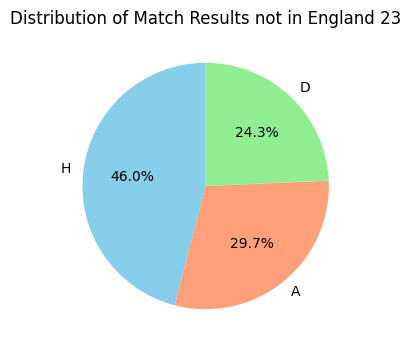

In [14]:
# Calculate value counts for 'result' column
result_counts = train['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results not in England 23")
plt.show()


In [15]:
train_columns=train.columns

In [16]:
X_train=train.drop(['label','FTR'], axis=1)
y_train=train['label']

In [17]:
train_columns=X_train.columns

In [18]:
test=seasons_df[(seasons_df['season'].isin(['season23']))]
test=test.copy()
test.drop('season', axis=1, inplace=True)

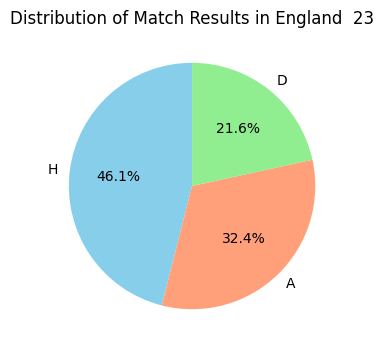

In [19]:
# Calculate value counts for 'result' column
result_counts = test['FTR'].value_counts()

# Define the colors in the same order as the labels
color_mapping = {'A': '#FFA07A',  # Light salmon (matte orange)
                 'H': '#87CEEB',  # Sky blue (matte blue)
                 'D': '#90EE90'}  # Light green (matte green)
colors = [color_mapping[label] for label in result_counts.index]

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(result_counts, labels=result_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Match Results in England  23")
plt.show()


In [20]:
test=test.drop([ 'FTR'], axis=1)
y_test=test['label']

In [21]:
len(y_test)

380

### Scale the features

In [22]:
scaling_columns=X_train.columns

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


In [24]:
test=test.copy()
test[scaling_columns]=scaler.transform(test[scaling_columns])

### Looping through each date and incrementally train and predict

In [25]:
best_params = {
    'colsample_bytree': 0.60,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 400,
    'gamma': 0.4, # low value means more splits
    'reg_alpha': 0.37, # higher values reduce over fitting
    'reg_lambda': 0.79, # higher values reduce over fittin
    'subsample': 0.25
}

model = xgb.XGBClassifier(**best_params)

In [37]:
best_params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 100
}

model = xgb.XGBClassifier(**best_params)

In [27]:
# Initialize model and train on initial training data
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
test = test.sort_values('Date')
unique_dates = test['Date'].unique()

In [29]:
%%time
#Wall time: 9min 51s

predictions = []
probabilities = []
accuracies =  []
batchsizes = []
acc_batch = []


test_batches_with_predictions = []

for date in unique_dates:
    # Filter test data for the current date
    test_batch = test[test['Date'] == date].copy()
    X_test_batch = test_batch.drop(columns=['label', 'Date'])
    y_test_batch = test_batch['label']
    
    # Make predictions and get probabilities for the current batch
    y_pred_batch = model.predict(X_test_batch)
    y_proba_batch = model.predict_proba(X_test_batch)  # Get probabilities
    probabilities.extend(y_proba_batch)

    # Add predictions and probabilities to the test batch
    test_batch['predictions'] = y_pred_batch
    proba_df = pd.DataFrame(
        y_proba_batch, 
        columns=[f'proba_{class_name}' for class_name in label_encoder.classes_]
    )

    test_batch = pd.concat([test_batch.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)

    test_batches_with_predictions.append(test_batch)
    
    # collect metrics
    predictions.extend(y_pred_batch)
    probabilities.extend(y_proba_batch)
    accuracies.append(accuracy_score(y_test_batch, y_pred_batch))
    batchsizes.append( len(X_test_batch))
    acc_batch.append(accuracy_score(y_test_batch, y_pred_batch) * len(X_test_batch))
    
    # Calculate and display metrics if desired (e.g., accuracy for this batch)
    print(f"Date: {date} - Accuracy: {accuracy_score(y_test_batch, y_pred_batch):.4f} - BatchSize: {len(X_test_batch)}")

    
    # Update model with the current batch
    X_all=np.concatenate([X_train, X_test_batch.to_numpy()], axis=0)
    y_all=pd.concat([y_train, y_test_batch])
    #import ipdb; ipdb.set_trace()
    model.fit(X_all, y_all)
    X_train=X_all
    y_train=y_all



# Collect all predictions for further evaluation if needed
test=test.copy()
#test['predictions'] = predictions

Date: 2023-08-11 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-12 00:00:00 - Accuracy: 0.6667 - BatchSize: 6
Date: 2023-08-13 00:00:00 - Accuracy: 0.0000 - BatchSize: 2
Date: 2023-08-14 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-18 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-19 00:00:00 - Accuracy: 0.8000 - BatchSize: 5
Date: 2023-08-20 00:00:00 - Accuracy: 0.5000 - BatchSize: 2
Date: 2023-08-21 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-25 00:00:00 - Accuracy: 1.0000 - BatchSize: 1
Date: 2023-08-26 00:00:00 - Accuracy: 0.3333 - BatchSize: 6
Date: 2023-08-27 00:00:00 - Accuracy: 0.6667 - BatchSize: 3
Date: 2023-09-01 00:00:00 - Accuracy: 0.0000 - BatchSize: 1
Date: 2023-09-02 00:00:00 - Accuracy: 0.5000 - BatchSize: 6
Date: 2023-09-03 00:00:00 - Accuracy: 1.0000 - BatchSize: 3
Date: 2023-09-16 00:00:00 - Accuracy: 0.8571 - BatchSize: 7
Date: 2023-09-17 00:00:00 - Accuracy: 0.5000 - BatchSize: 2
Date: 2023-09-18 00:00:00 - Accuracy: 0.

In [30]:
test_with_predictions = pd.concat(test_batches_with_predictions, axis=0)

In [31]:
np.cumsum(acc_batch)

array([  1.,   5.,   5.,   6.,   7.,  11.,  12.,  13.,  14.,  16.,  18.,
        18.,  21.,  24.,  30.,  31.,  31.,  33.,  36.,  40.,  41.,  42.,
        43.,  49.,  50.,  55.,  56.,  57.,  58.,  60.,  63.,  68.,  68.,
        68.,  70.,  73.,  78.,  79.,  80.,  85.,  87.,  89.,  93.,  93.,
        94.,  97.,  98., 101., 104., 104., 104., 105., 105., 108., 110.,
       111., 116., 117., 118., 118., 118., 120., 120., 122., 123., 123.,
       125., 128., 128., 130., 132., 133., 137., 138., 139., 143., 145.,
       145., 146., 147., 151., 152., 152., 157., 159., 160., 163., 164.,
       165., 166., 166., 166., 170., 171., 172., 174., 176., 179., 180.,
       182., 182., 183., 186., 190., 191., 194., 195., 198., 201., 202.,
       203., 207., 210., 211., 217., 218., 218., 219., 221., 230.])

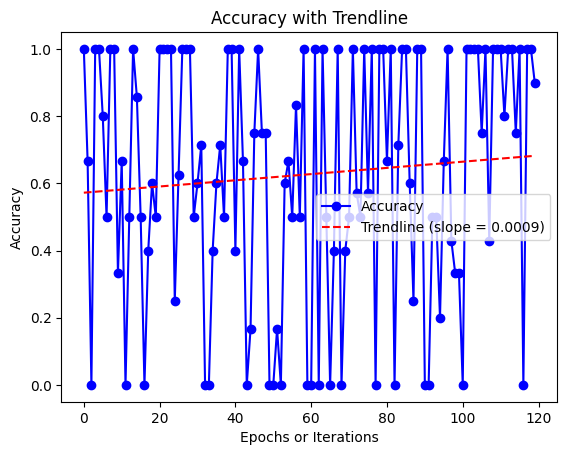

In [32]:

# Generate an array of indices (x-values)
x = np.arange(len(accuracies))

# Create a plot of the accuracies
plt.plot(x, accuracies, label='Accuracy', color='blue', marker='o')

# Calculate the trendline (slope) using polyfit (1st degree polynomial = line)
slope, intercept = np.polyfit(x, accuracies, 1)

# Generate the trendline y-values using the calculated slope and intercept
trendline = slope * x + intercept

# Plot the trendline
plt.plot(x, trendline, label=f'Trendline (slope = {slope:.4f})', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Epochs or Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy with Trendline')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [33]:
y_pred = test_with_predictions['predictions']

In [34]:
y_pred_labels = label_encoder.inverse_transform(test_with_predictions['predictions'])
y_test_labels = label_encoder.inverse_transform(test_with_predictions['label'])

In [35]:

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

Classification Report:
              precision    recall  f1-score   support

           A       0.58      0.65      0.61       123
           D       0.75      0.04      0.07        82
           H       0.62      0.84      0.71       175

    accuracy                           0.61       380
   macro avg       0.65      0.51      0.46       380
weighted avg       0.63      0.61      0.54       380



In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
xlabel=ylabel=label_encoder.inverse_transform(model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xlabel, yticklabels=ylabel)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

AttributeError: 'XGBClassifier' object has no attribute 'n_classes_'

<Figure size 800x600 with 0 Axes>

## trying again with different params

In [35]:
# Get feature importances
feature_importances = model.feature_importances_


feature_names = train_columns  # If you're using a DataFrame for X_train
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

importance_df


,Feature,Importance
6,AvgH,0.338715
10,AvgA,0.059686
2,B365H,0.048096
8,AvgD,0.040559
5,MaxH,0.036234
9,MaxA,0.025333
7,MaxD,0.013602
37,diff.last3.shots_against,0.011847
44,diff.last3.yellows,0.011708
36,diff.last3.shots,0.011629


### My Results

In [39]:
test_with_predictions = pd.concat(test_batches_with_predictions, axis=0)

In [40]:
test[['predictions','proba_A','proba_D','proba_H']] = test_with_predictions[['predictions','proba_A','proba_D','proba_H']].values

In [41]:
my_predictions=test.sort_index()[['predictions','proba_A','proba_D','proba_H']]
my_predictions['predictions']=label_encoder.inverse_transform(my_predictions['predictions'].astype(int))

In [42]:
myresults=pd.concat([my_test_set, my_predictions ,], axis=1)

In [43]:
myresults=myresults[['Date','HomeTeam','AwayTeam', 'FTR', 'season', 'B365H', 'B365D', 'B365A','MaxH', 'AvgH', 'MaxD', 'AvgD', 'MaxA',
       'AvgA','predictions', 'proba_H', 'proba_D', 'proba_A']]

In [44]:
myresults.to_pickle('data/match_predictions.pkl')

In [45]:
myresults

,Date,HomeTeam,AwayTeam,FTR,season,B365H,B365D,B365A,MaxH,AvgH,MaxD,AvgD,MaxA,AvgA,predictions,proba_H,proba_D,proba_A
6840,2023-08-11,Burnley,Man City,A,season23,8.00,5.50,1.33,9.50,9.02,5.68,5.35,1.39,1.35,A,0.208388,0.243915,0.547697
6841,2023-08-12,Arsenal,Nott'm Forest,H,season23,1.18,7.00,15.00,1.21,1.18,8.50,7.64,17.50,15.67,H,0.658375,0.171784,0.169841
6842,2023-08-12,Bournemouth,West Ham,D,season23,2.70,3.40,2.55,2.80,2.69,3.62,3.44,2.75,2.64,A,0.340656,0.311815,0.347529
6843,2023-08-12,Brighton,Luton,H,season23,1.33,5.50,9.00,1.36,1.33,6.00,5.52,10.50,9.61,H,0.544671,0.245741,0.209588
6844,2023-08-12,Everton,Fulham,A,season23,2.20,3.40,3.30,2.30,2.24,3.57,3.43,3.45,3.30,H,0.364506,0.303388,0.332106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7215,2024-05-19,Crystal Palace,Aston Villa,H,season23,1.85,4.33,3.60,1.93,1.87,4.50,4.28,3.84,3.67,H,0.429992,0.279912,0.290096
7216,2024-05-19,Liverpool,Wolves,H,season23,1.17,8.00,15.00,1.18,1.16,10.00,8.71,17.00,14.55,H,0.586533,0.227369,0.186098
7217,2024-05-19,Luton,Fulham,A,season23,2.90,3.90,2.20,3.00,2.92,4.35,3.95,2.30,2.23,A,0.321672,0.255968,0.422360
7218,2024-05-19,Man City,West Ham,H,season23,1.08,12.00,21.00,1.11,1.10,14.00,11.72,25.00,21.81,H,0.601762,0.230930,0.167309
